# Anomaly Detection in ECG samples

Import the required libraries and load the data. Here we are using the ECG data which consists of labels 0 and 1. Label 0 denotes the observation as an anomaly and label 1 denotes the observation as normal.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

# Download the dataset
PATH_TO_DATA = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
data = pd.read_csv(PATH_TO_DATA, header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [30]:
# explore the data
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Columns: 141 entries, 0 to 140
dtypes: float64(141)
memory usage: 5.4 MB


,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
count,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,...,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000
mean,-0.262502,-1.649828,-2.492623,-3.119754,-3.167656,-2.866306,-2.272845,-1.797754,-1.409784,-0.935806,...,0.071312,-0.062622,-0.276086,-0.507750,-0.761323,-0.835173,-0.642739,-0.487667,-0.706574,0.584034
std,1.152450,1.445542,1.386457,1.302921,1.104535,0.906312,0.731594,0.622794,0.636863,0.657788,...,1.404425,1.646105,1.894515,2.059366,2.086130,2.056296,1.859409,1.831088,1.414414,0.492937
min,-6.729499,-7.090374,-5.132459,-5.363241,-5.375715,-5.330194,-4.782240,-4.311288,-4.071361,-4.142476,...,-4.167040,-4.557576,-4.530488,-4.563270,-5.150100,-4.880460,-5.496107,-5.880890,-6.092227,0.000000
25%,-1.004220,-2.701936,-3.668585,-4.227337,-4.007630,-3.480666,-2.779832,-2.165808,-1.773870,-1.362003,...,-1.087720,-1.588237,-2.146835,-2.730750,-3.031224,-2.868603,-2.154560,-1.658289,-1.596809,0.000000
50%,-0.297541,-1.661892,-2.586129,-3.388210,-3.469899,-2.947061,-2.285427,-1.750084,-1.422457,-0.910384,...,0.658318,0.717808,0.604747,0.334857,-0.030767,-0.195151,-0.194423,-0.160262,-0.568443,1.000000
75%,0.499909,-0.677998,-1.514187,-2.235690,-2.531153,-2.398797,-1.823480,-1.484107,-1.063592,-0.476477,...,1.169392,1.238651,1.264379,1.234408,1.033957,0.945027,0.951621,1.002628,0.271635,1.000000
max,4.966414,3.479689,2.660597,1.899798,2.147015,1.614375,1.868728,1.804251,1.683730,1.898627,...,3.007606,2.854680,2.912394,2.937685,3.351437,3.432519,3.579448,4.425976,7.402103,1.000000


In [28]:
# check for missing values
data.isnull().sum()

0      0
1      0
2      0
3      0
4      0
      ..
136    0
137    0
138    0
139    0
140    0
Length: 141, dtype: int64

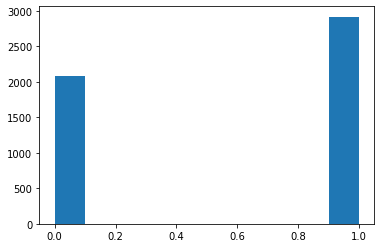

In [31]:
# last column is the target
# 0 = anomaly, 1 = normal
TARGET = 140  # column name is 140

# remove the target column from the data
features = data.drop(TARGET, axis=1)
target = data[TARGET]

# plot an histogram of the target
plt.hist(target, bins=10)
plt.show()



We can see the dataset is already well balanced between the two categories

In [8]:
# split to train and test
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

In [24]:
print(x_test.shape)
print(x_train.shape)

(1000, 140)
(3998, 140)


In [9]:
# we use normal data only for training
train_index = y_train[y_train == 1].index
train_data = x_train.loc[train_index]

In [10]:
# scale the dataset
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

The encoder of the model consists of four layers that encode the data into lower dimensions. The decoder of the model consists of four layers that reconstruct the input data.<br>
I'll be using Mean Squared Logarithmic loss function

In [12]:
# create a model by subclassing Model class in tensorflow

class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

fit_data = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/20
5/5 [==============================] - 1s 44ms/step - loss: 0.0109 - mse: 0.0246 - val_loss: 0.0132 - val_mse: 0.0307
Epoch 2/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0106 - mse: 0.0238 - val_loss: 0.0129 - val_mse: 0.0300
Epoch 3/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0098 - mse: 0.0222 - val_loss: 0.0125 - val_mse: 0.0291
Epoch 4/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0088 - mse: 0.0198 - val_loss: 0.0121 - val_mse: 0.0282
Epoch 5/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0077 - mse: 0.0173 - val_loss: 0.0116 - val_mse: 0.0270
Epoch 6/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0067 - mse: 0.0152 - val_loss: 0.0112 - val_mse: 0.0260
Epoch 7/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0060 - mse: 0.0134 - val_loss: 0.0108 - val_mse: 0.0251
Epoch 8/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0055 - mse: 0.0123 - val

#### Lets see the loss behavior along the epochs

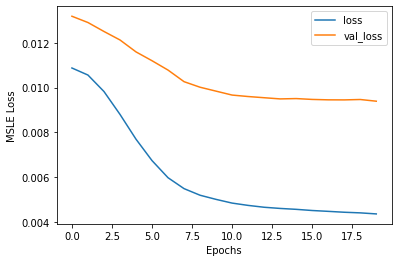

In [13]:
plt.plot(fit_data.history['loss'])
plt.plot(fit_data.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

clearly there is significant loss reduction for the first 16 epochs

#### now I'll make some predictions and evaluations

In [14]:
def find_threshold(model, x_train_scaled):
    """The threshold is then calculated by summing the mean and standard deviation of the reconstruction errors. 

    Args:
        model : autoencoder model
        x_train_scaled : training data

    """
    reconstructions = model.predict(x_train_scaled)

    # provides losses of individual instances
    reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

    # threshold for anomaly scores
    threshold = np.mean(reconstruction_errors.numpy()) \
        + np.std(reconstruction_errors.numpy())

    return threshold

def get_predictions(model, x_test_scaled, threshold):
    """_summary_

    Args:
        model: the trained autoencoder model
        x_test_scaled (numpy matrix): the dta matrix to be predicted
        threshold (_type_): the calculated threshold for anomaly scores

    Returns:
        _type_: _description_
    """
    predictions = model.predict(x_test_scaled)
    # provides losses of individual instances
    errors = tf.keras.losses.msle(predictions, x_test_scaled)
    # 0 = anomaly, 1 = normal
    anomaly_mask = pd.Series(errors) > threshold
    preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
    return preds

In [15]:
# calculate the threshold
threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")

Threshold: 0.009445449970015615


 The reconstruction errors above this threshold are considered to be anomalies. We can further fine-tune the model by leveraging Keras-tuner.

In [59]:
# make a prediction
predictions = get_predictions(model, x_test_scaled, threshold)


In [32]:
print(len(predictions))
predictions.head()

1000


0    0.0
1    0.0
2    0.0
3    1.0
4    0.0
dtype: float64

In [33]:
x_test.head()

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
3815,1.113102,0.095296,-0.994161,-1.798282,-2.572368,-3.154750,-3.186723,-2.961793,-2.757656,-2.403351,...,-2.209882,-2.477614,-2.753869,-3.008447,-2.970085,-2.309163,-1.191342,-0.188725,0.561955,1.191669
4317,0.188726,-0.485056,-1.086554,-1.865067,-2.553625,-3.145773,-3.324481,-3.235811,-2.958564,-2.325412,...,-1.764636,-2.204946,-2.729176,-3.158301,-3.125594,-2.562267,-1.531784,-0.421233,0.218241,0.801041
859,3.980522,3.267519,1.028781,-0.026786,-0.941046,-1.378094,-0.624001,0.483763,0.701762,1.007102,...,-1.435306,-1.083289,-0.674679,-0.673464,-0.148893,-0.002255,0.176893,-0.576331,-0.185614,-0.268612
753,-1.208206,-2.849256,-3.259359,-3.897344,-3.878372,-3.181792,-1.823501,-1.332275,-1.045400,-0.282673,...,1.405917,1.417346,0.730849,-0.072667,-1.144872,-2.147702,-2.512742,-2.055890,-1.163876,-2.051793
857,0.035905,-1.096121,-1.748323,-2.274039,-2.136716,-1.601248,-0.627307,-0.386102,-0.122775,0.310057,...,-1.198738,-1.505539,-1.516595,-1.329379,-1.683483,-2.709445,-3.546228,-4.157195,-4.163507,-4.231048


In [19]:
# calculate the accuracy
accuracy_score(predictions, y_test)

0.946

In [66]:
test_data.columns[-1]

0

In [67]:

#drop index
x_test.reset_index(drop=True, inplace=True)

# rename the predictions series
predictions.rename("labels", inplace=True)

# concat the predictions to the original test data
test_data = pd.concat([x_test, predictions], axis=1)

# rename last column to 'anomaly_label'
#test_data.rename(columns={test_data.columns[-1]: 'anomaly_label'}, inplace=True)

print(test_data.shape)
test_data.head(n=20)

(1000, 141)


,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,labels
0,1.113102,0.095296,-0.994161,-1.798282,-2.572368,-3.154750,-3.186723,-2.961793,-2.757656,-2.403351,...,-2.477614,-2.753869,-3.008447,-2.970085,-2.309163,-1.191342,-0.188725,0.561955,1.191669,0.0
1,0.188726,-0.485056,-1.086554,-1.865067,-2.553625,-3.145773,-3.324481,-3.235811,-2.958564,-2.325412,...,-2.204946,-2.729176,-3.158301,-3.125594,-2.562267,-1.531784,-0.421233,0.218241,0.801041,0.0
2,3.980522,3.267519,1.028781,-0.026786,-0.941046,-1.378094,-0.624001,0.483763,0.701762,1.007102,...,-1.083289,-0.674679,-0.673464,-0.148893,-0.002255,0.176893,-0.576331,-0.185614,-0.268612,0.0
3,-1.208206,-2.849256,-3.259359,-3.897344,-3.878372,-3.181792,-1.823501,-1.332275,-1.045400,-0.282673,...,1.417346,0.730849,-0.072667,-1.144872,-2.147702,-2.512742,-2.055890,-1.163876,-2.051793,1.0
4,0.035905,-1.096121,-1.748323,-2.274039,-2.136716,-1.601248,-0.627307,-0.386102,-0.122775,0.310057,...,-1.505539,-1.516595,-1.329379,-1.683483,-2.709445,-3.546228,-4.157195,-4.163507,-4.231048,0.0
5,1.191927,-0.164585,-2.410937,-3.984765,-4.109857,-3.266428,-2.316887,-1.898800,-1.630999,-0.909287,...,0.906078,1.091141,1.403044,1.621390,1.484643,1.210550,1.099949,1.442955,0.501361,1.0
6,-0.367521,-1.378609,-1.681929,-2.319883,-2.497559,-2.633110,-2.674103,-2.504238,-2.208917,-1.672797,...,-2.380032,-3.022026,-3.653582,-3.641566,-3.181995,-2.329324,-1.235168,-0.770028,0.600774,0.0
7,-0.021964,-0.912434,-1.903353,-2.662829,-3.122156,-3.451490,-3.392982,-2.929937,-2.256294,-1.690706,...,1.339479,1.457995,2.128078,2.630759,2.295748,1.764967,1.444280,1.432347,1.457028,0.0
8,0.982633,0.494472,-0.241144,-1.025917,-1.408439,-1.694038,-2.041352,-1.999404,-1.492510,-0.926151,...,-1.461557,-1.499390,-1.767507,-2.051630,-2.624433,-3.228672,-3.958803,-4.773353,-5.466426,0.0
9,-1.673221,-2.652744,-3.243058,-3.879866,-3.678488,-3.002778,-2.033916,-1.794833,-1.553645,-0.955528,...,1.341013,0.998582,0.519328,-0.099310,-0.381263,-0.539373,-0.412185,0.069817,0.031422,1.0


#### I'll use TSNE to do dimensionality reduction to visulize the data seperation according to the labels

In [68]:
# dimensionality reduction with tsne
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(test_data.drop('labels', axis=1))


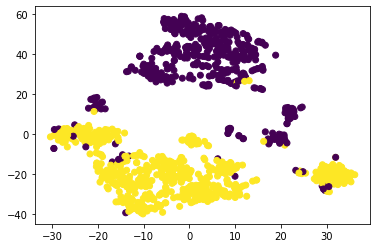

In [70]:
# plot the results of tsne
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=test_data['labels'])
plt.show()


##### We can see clear seperations between the labels and the features